In [ ]:
!pip install prophet

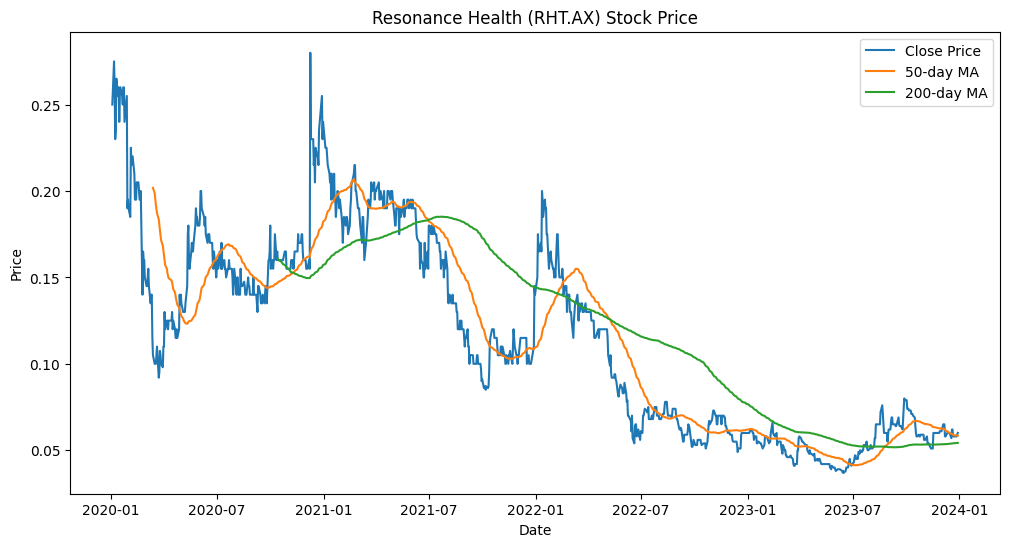

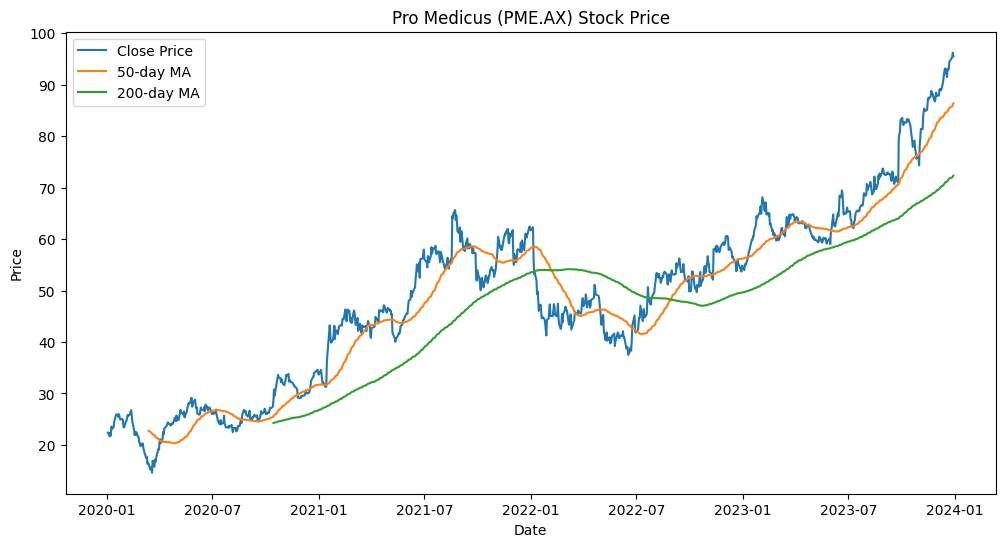

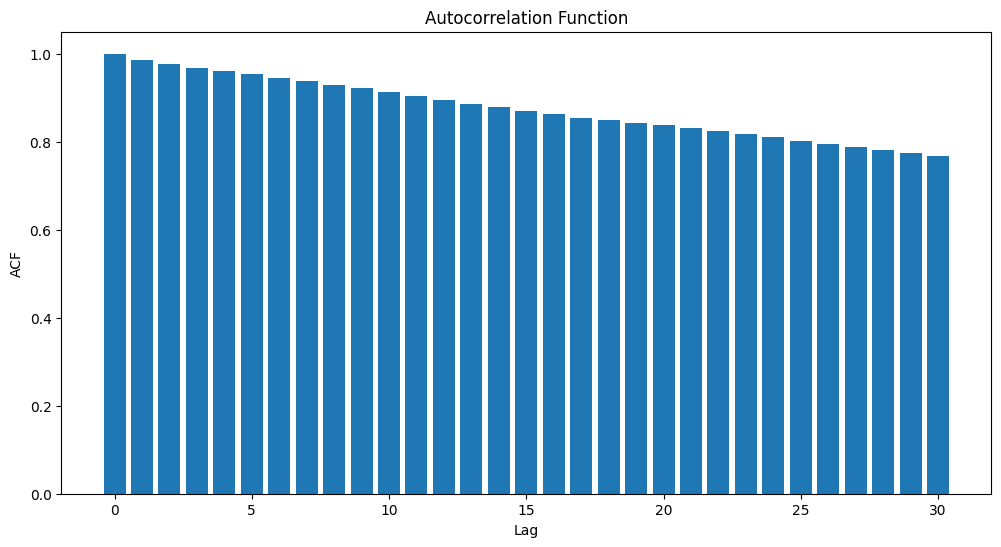

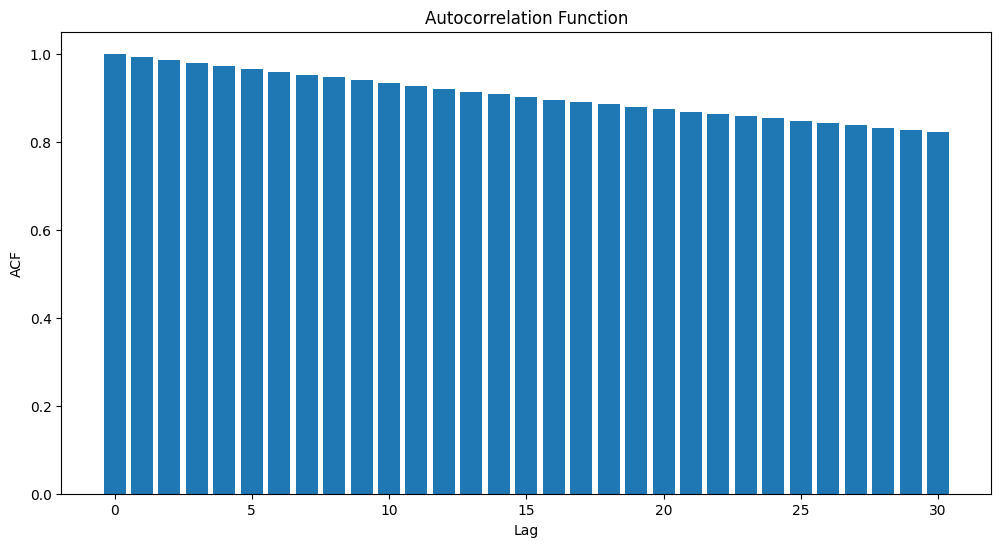

c:\Users\madok\madoka coding\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\madok\madoka coding\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\madok\madoka coding\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\madok\madoka coding\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupport

RHT ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1011
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3453.466
Date:                Tue, 22 Oct 2024   AIC                          -6900.932
Time:                        10:54:57   BIC                          -6886.178
Sample:                             0   HQIC                         -6895.327
                               - 1011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1007      0.090     -1.116      0.264      -0.278       0.076
ma.L1         -0.1778      0.090     -1.966      0.049      -0.355      -0.001
sigma2      6.274e-05   5.05e-07 

10:54:57 - cmdstanpy - INFO - Chain [1] done processing
10:54:57 - cmdstanpy - INFO - Chain [1] start processing
10:54:57 - cmdstanpy - INFO - Chain [1] done processing


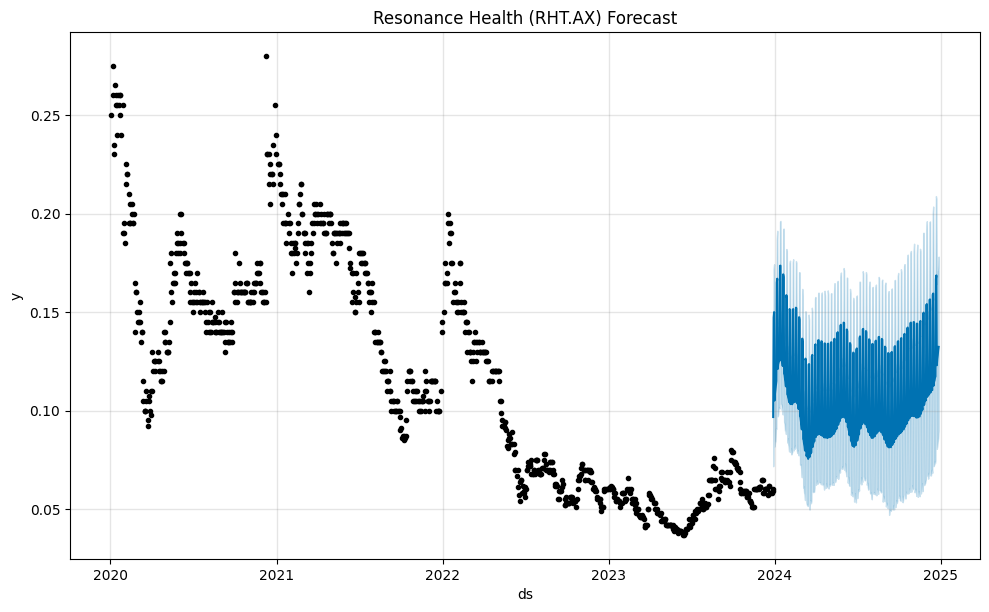

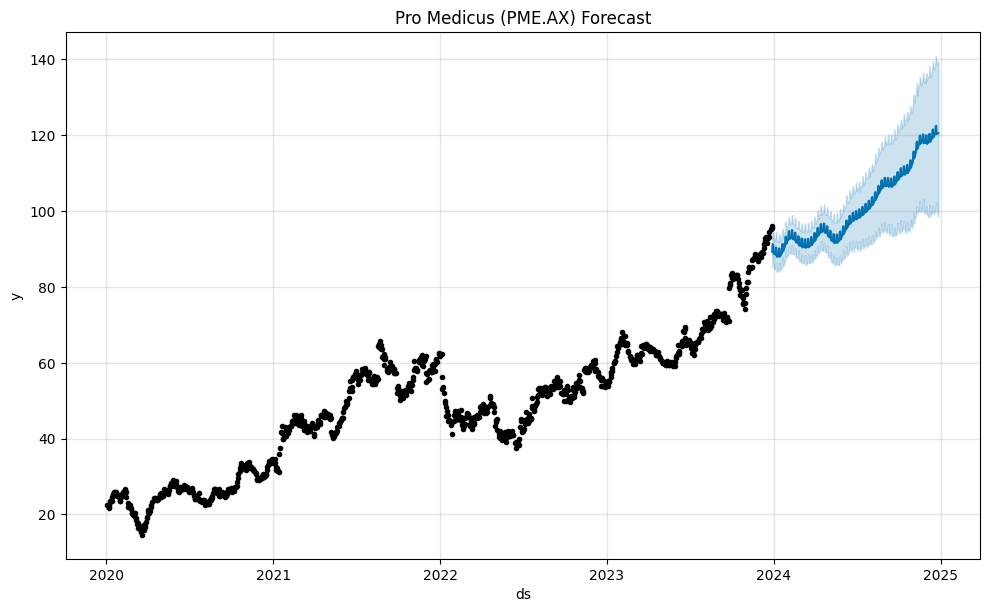


RHT Forecast Metrics:
MAE: 0.01
MSE: 0.00
RMSE: 0.02
R2: 0.89

PME Forecast Metrics:
MAE: 2.46
MSE: 9.10
RMSE: 3.02
R2: 0.97


In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# データの取得
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    return df

# データの前処理
def preprocess_data(df):
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
    df['Close_Prev'] = df['Close'].shift(1)
    df['Return'] = (df['Close'] - df['Close_Prev']) / df['Close_Prev']
    df['Open_Close_Diff'] = df['Close'] - df['Open']
    df = df.dropna()
    return df

# 移動平均の計算
def add_moving_average(df, window):
    df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

# データの可視化
def plot_stock_data(df, title):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.plot(df['Date'], df['MA_50'], label='50-day MA')
    plt.plot(df['Date'], df['MA_200'], label='200-day MA')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# 自己相関分析
def plot_autocorrelation(df):
    acf_values = acf(df['Close'])
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(acf_values)), acf_values)
    plt.title('Autocorrelation Function')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.show()

# ARIMA モデル
def fit_arima_model(df):
    model = ARIMA(df['Close'], order=(1, 1, 1))
    results = model.fit()
    return results

# Prophet モデル
def fit_prophet_model(df):
    prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    model = Prophet()
    model.fit(prophet_df)
    return model

# 予測評価指標の計算
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# メイン処理
if __name__ == "__main__":
    # データ取得
    rht_df = get_stock_data("RHT.AX", "2020-01-01", "2023-12-31")
    pme_df = get_stock_data("PME.AX", "2020-01-01", "2023-12-31")

    # データ前処理
    rht_df = preprocess_data(rht_df)
    pme_df = preprocess_data(pme_df)

    # 移動平均の追加
    rht_df = add_moving_average(rht_df, 50)
    rht_df = add_moving_average(rht_df, 200)
    pme_df = add_moving_average(pme_df, 50)
    pme_df = add_moving_average(pme_df, 200)

    # データ可視化
    plot_stock_data(rht_df, "Resonance Health (RHT.AX) Stock Price")
    plot_stock_data(pme_df, "Pro Medicus (PME.AX) Stock Price")

    # 自己相関分析
    plot_autocorrelation(rht_df)
    plot_autocorrelation(pme_df)

    # ARIMA モデル
    rht_arima = fit_arima_model(rht_df)
    pme_arima = fit_arima_model(pme_df)

    print("RHT ARIMA Summary:")
    print(rht_arima.summary())
    print("\nPME ARIMA Summary:")
    print(pme_arima.summary())

    # Prophet モデル
    rht_prophet = fit_prophet_model(rht_df)
    pme_prophet = fit_prophet_model(pme_df)

    # 将来予測
    future_dates = pd.date_range(start=rht_df['Date'].iloc[-1], periods=365)
    future_df = pd.DataFrame({'ds': future_dates})

    rht_forecast = rht_prophet.predict(future_df)
    pme_forecast = pme_prophet.predict(future_df)

    # 予測結果の可視化
    fig1 = rht_prophet.plot(rht_forecast)
    plt.title("Resonance Health (RHT.AX) Forecast")
    plt.show()

    fig2 = pme_prophet.plot(pme_forecast)
    plt.title("Pro Medicus (PME.AX) Forecast")
    plt.show()

    # 予測評価
    rht_mae, rht_mse, rht_rmse, rht_r2 = calculate_metrics(rht_df['Close'], rht_prophet.predict(rht_df[['Date']].rename(columns={'Date': 'ds'}))['yhat'])
    pme_mae, pme_mse, pme_rmse, pme_r2 = calculate_metrics(pme_df['Close'], pme_prophet.predict(pme_df[['Date']].rename(columns={'Date': 'ds'}))['yhat'])

    print("\nRHT Forecast Metrics:")
    print(f"MAE: {rht_mae:.2f}")
    print(f"MSE: {rht_mse:.2f}")
    print(f"RMSE: {rht_rmse:.2f}")
    print(f"R2: {rht_r2:.2f}")

    print("\nPME Forecast Metrics:")
    print(f"MAE: {pme_mae:.2f}")
    print(f"MSE: {pme_mse:.2f}")
    print(f"RMSE: {pme_rmse:.2f}")
    print(f"R2: {pme_r2:.2f}")

In [23]:
!pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 3.4 MB/s eta 0:00:03
   ----- ---------------------------------- 1.6/11.0 MB 3.2 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/11.0 MB 3.1 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.0 MB 3.1 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/11.0 MB 3.1 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/11.0 MB 3.0 MB/s eta 0:00:03
   ----------------- ---------------------- 4.7/11.0 MB 3.0 MB/s eta 0:00:03
   ------------------- -------------------- 5.2/11.0 MB 3.0 MB/s eta 0:00:02
   --------------------- ------------------ 6.0/11.0 MB 3.0 MB/s eta 0:00:02
   ----------------------- --------

In [14]:
import sys
print(sys.executable)

c:\Users\madok\madoka coding\.venv\Scripts\python.exe


In [15]:
!pip list

Package            Version
------------------ -----------
asttokens          2.4.1
attrs              24.2.0
beautifulsoup4     4.12.3
certifi            2024.6.2
cffi               1.17.1
charset-normalizer 3.3.2
colorama           0.4.6
comm               0.2.2
contourpy          1.2.1
cycler             0.12.1
Cython             3.0.10
debugpy            1.8.7
decorator          5.1.1
exceptiongroup     1.2.2
executing          2.1.0
fonttools          4.53.0
h11                0.14.0
idna               3.7
ipykernel          6.29.5
ipython            8.28.0
jedi               0.19.1
jupyter_client     8.6.3
jupyter_core       5.7.2
kiwisolver         1.4.5
matplotlib         3.9.0
matplotlib-inline  0.1.7
nest-asyncio       1.6.0
numpy              2.1.2
opencv-python      4.10.0.84
outcome            1.3.0.post0
packaging          24.0
pandas             2.2.2
parso              0.8.4
pillow             10.3.0
pip                24.2
platformdirs       4.3.6
prompt_toolkit     3.0

In [16]:
!pip install yfinance --no-cache-dir

     ---------------------------------------- 0.0/939.5 kB ? eta -:--:--
     --------------------- ---------------- 524.3/939.5 kB 8.5 MB/s eta 0:00:01
     -------------------------------------- 939.5/939.5 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.5/3.8 MB 2.8 MB/s eta 0:00:02
   ----------- ---------------------------- 1.0/3.8 MB 2.8 MB/s eta 0:00:01
   ------------------- -------------------- 1.8/3.8 MB 2.9 MB/s eta 0:00:01
   ------------------------ --------------- 2.4/3.8 MB 2.9 MB/s eta 0:00:01
   ------------------------------ --------- 2.9/3.8 MB 2.9 MB/s 

In [18]:
!pip install statsmodels

  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.8 MB 3.1 MB/s eta 0:00:03
   ------ --------------------------------- 1.6/9.8 MB 3.1 MB/s eta 0:00:03
   --------- ------------------------------ 2.4/9.8 MB 3.0 MB/s eta 0:00:03
   ----------- ---------------------------- 2.9/9.8 MB 3.0 MB/s eta 0:00:03
   -------------- ------------------------- 3.7/9.8 MB 3.0 MB/s eta 0:00:03
   ----------------- ---------------------- 4.2/9.8 MB 3.0 MB/s eta 0:00:02
   ------------------- -------------------- 4.7/9.8 MB 3.0 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.8 MB 3.0 MB/s eta 0:00:02
   ------------------------ --------------- 6.0/9.8 MB 3.0 MB/s eta 0:00:02
   -------------------------- ------------- 6.6/9.8 MB 3.0 MB/s eta 0:00:02
   ---------------------------- ----